# 01 - Data Exploration
## Khám phá dữ liệu Sentinel-1, Sentinel-2 và Ground Truth

Notebook này sẽ:
- Load và phân tích dữ liệu ground truth (1285 điểm)
- Đọc và hiển thị thông tin ảnh Sentinel-1 và Sentinel-2
- Visualize RGB composite và các spectral indices
- Kiểm tra phân bố labels và vị trí các điểm
- Trích xuất và visualize một số patches mẫu

In [1]:
import sys
sys.path.append('..')  # Add parent directory to path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from rasterio.plot import show
from pathlib import Path
import os

# Import project modules
from src.config import *
from src.utils import read_geotiff, normalize_image, normalize_sentinel2, coords_to_pixel
from src.preprocessing import load_ground_truth, extract_patch_at_point

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Create figures directory if it doesn't exist
FIGURES_DIR = Path(PROJECT_ROOT) / 'figures'
FIGURES_DIR.mkdir(exist_ok=True)
print(f"Figures will be saved to: {FIGURES_DIR}")

print("Libraries loaded successfully!")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")

Figures will be saved to: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures
Libraries loaded successfully!
Project root: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..
Data directory: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\data


## 1. Load và phân tích Ground Truth

In [2]:
# Load ground truth CSV
df = load_ground_truth()

# Display first few rows
print("\nFirst 10 rows:")
df.head(10)

Loaded 1285 ground truth points
  - No deforestation (0): 650
  - Deforestation (1): 635

First 10 rows:


,id,label,x,y
0,351,1,495551.110218,1.054432e+06
1,352,1,495451.786737,1.054588e+06
2,353,1,495391.097161,1.054524e+06
3,354,1,495664.635289,1.054353e+06
4,355,1,495610.798117,1.054299e+06
5,356,1,496706.522336,1.054520e+06
6,357,1,496726.584917,1.054502e+06
7,358,1,496685.963731,1.054462e+06
8,359,1,496636.045419,1.054433e+06
9,360,1,496666.873913,1.054412e+06


In [3]:
# Basic statistics
print("Dataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1285 non-null   int64  
 1   label   1285 non-null   int64  
 2   x       1285 non-null   float64
 3   y       1285 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 40.3 KB
None

Basic statistics:
                id        label              x             y
count  1285.000000  1285.000000    1285.000000  1.285000e+03
mean   1180.782101     0.494163  504952.989734  1.001523e+06
std     532.829432     0.500161   19869.198606  3.423688e+04
min     351.000000     0.000000  476428.116678  9.483253e+05
25%     677.000000     0.000000  489448.961958  9.720617e+05
50%    1356.000000     0.000000  496832.139123  9.915942e+05
75%    1677.000000     1.000000  521610.656136  1.033932e+06
max    1998.000000     1.000000  545098.055002  1.054588e+06



Label distribution:
  No deforestation (0): 650 (50.6%)
  Deforestation (1): 635 (49.4%)
Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\01_label_distribution.png


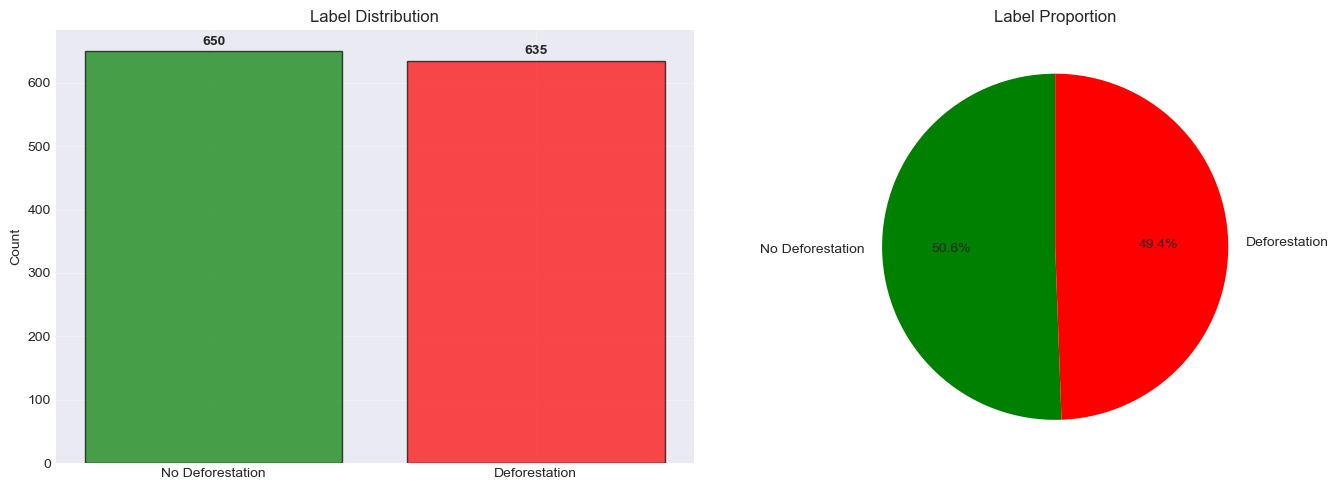

In [4]:
# Analyze label distribution
label_counts = df['label'].value_counts()
print("\nLabel distribution:")
print(f"  No deforestation (0): {label_counts[0]} ({label_counts[0]/len(df)*100:.1f}%)")
print(f"  Deforestation (1): {label_counts[1]} ({label_counts[1]/len(df)*100:.1f}%)")

# Plot label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['No Deforestation', 'Deforestation'], label_counts.values, 
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution')
axes[0].grid(alpha=0.3)
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(label_counts.values, labels=['No Deforestation', 'Deforestation'],
            autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
axes[1].set_title('Label Proportion')

plt.tight_layout()
# Save figure
plt.savefig(FIGURES_DIR / '01_label_distribution.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '01_label_distribution.png'}")
plt.show()

## 2. Load và phân tích Sentinel-2 Imagery

In [5]:
# Load Sentinel-2 images
print("Loading Sentinel-2 2024...")
s2_2024, s2_2024_profile, s2_2024_transform = read_geotiff(SENTINEL2_2024)

print("\nLoading Sentinel-2 2025...")
s2_2025, s2_2025_profile, s2_2025_transform = read_geotiff(SENTINEL2_2025)

# Print information
print(f"\nS2 2024 shape: {s2_2024.shape}")
print(f"S2 2024 dtype: {s2_2024.dtype}")
print(f"S2 2024 CRS: {s2_2024_profile['crs']}")
print(f"S2 2024 transform: {s2_2024_transform}")

print(f"\nS2 2025 shape: {s2_2025.shape}")
print(f"S2 2025 dtype: {s2_2025.dtype}")

# Check for NaN values
print(f"\nS2 2024 has NaN: {np.isnan(s2_2024).any()}")
print(f"S2 2025 has NaN: {np.isnan(s2_2025).any()}")

# Value ranges
print(f"\nS2 2024 value range: [{np.nanmin(s2_2024):.2f}, {np.nanmax(s2_2024):.2f}]")
print(f"S2 2025 value range: [{np.nanmin(s2_2025):.2f}, {np.nanmax(s2_2025):.2f}]")

Loading Sentinel-2 2024...

Loading Sentinel-2 2025...

S2 2024 shape: (7, 10917, 12547)
S2 2024 dtype: float32
S2 2024 CRS: EPSG:32648
S2 2024 transform: | 10.00, 0.00, 465450.00|
| 0.00,-10.00, 1055820.00|
| 0.00, 0.00, 1.00|

S2 2025 shape: (7, 10917, 12547)
S2 2025 dtype: float32

S2 2024 has NaN: True
S2 2025 has NaN: True

S2 2024 value range: [-1.00, 1.00]
S2 2025 value range: [-1.00, 1.50]


In [6]:
# Check value range for each band individually
print("\n" + "="*60)
print("DETAILED VALUE RANGE FOR EACH BAND")
print("="*60)

for i, band_name in enumerate(S2_BANDS):
    min_2024 = np.nanmin(s2_2024[i])
    max_2024 = np.nanmax(s2_2024[i])
    mean_2024 = np.nanmean(s2_2024[i])
    
    min_2025 = np.nanmin(s2_2025[i])
    max_2025 = np.nanmax(s2_2025[i])
    mean_2025 = np.nanmean(s2_2025[i])
    
    print(f"\n{band_name}:")
    print(f"  2024: [{min_2024:7.3f}, {max_2024:7.3f}]  mean={mean_2024:7.3f}")
    print(f"  2025: [{min_2025:7.3f}, {max_2025:7.3f}]  mean={mean_2025:7.3f}")

print("\n" + "="*60)


DETAILED VALUE RANGE FOR EACH BAND

B4:
  2024: [  0.000,   0.814]  mean=  0.006
  2025: [  0.000,   0.664]  mean=  0.006

B8:
  2024: [  0.000,   0.759]  mean=  0.026
  2025: [  0.000,   0.624]  mean=  0.024

B11:
  2024: [  0.000,   0.583]  mean=  0.012
  2025: [  0.000,   0.643]  mean=  0.013

B12:
  2024: [  0.000,   0.983]  mean=  0.006
  2025: [  0.000,   1.502]  mean=  0.007

NDVI:
  2024: [ -1.000,   1.000]  mean=  0.067
  2025: [ -1.000,   1.000]  mean=  0.059

NBR:
  2024: [ -1.000,   1.000]  mean=  0.068
  2025: [ -1.000,   1.000]  mean=  0.059

NDMI:
  2024: [ -1.000,   1.000]  mean=  0.040
  2025: [ -1.000,   1.000]  mean=  0.031



Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\03_s2_all_bands_comparison.png


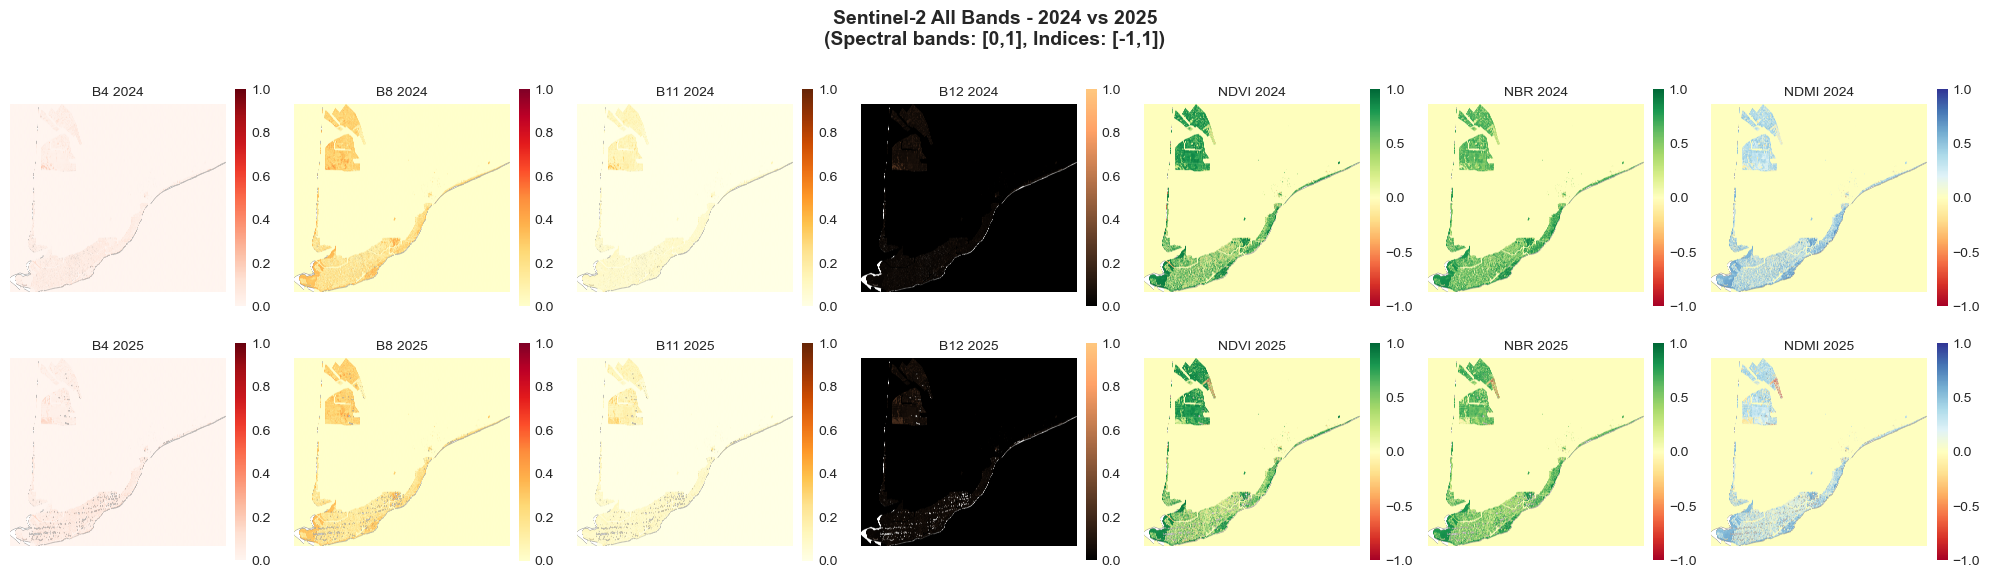

In [7]:
# Visualize individual bands for both 2024 and 2025
# Use appropriate colormaps and value ranges for each band type
band_names = S2_BANDS  # Get band names from config

colormaps = {
    'B4': 'Reds',      # Red band
    'B8': 'YlOrRd',    # NIR band
    'B11': 'YlOrBr',   # SWIR1 band
    'B12': 'copper',   # SWIR2 band
    'NDVI': 'RdYlGn',  # Vegetation index
    'NBR': 'RdYlGn',   # Burn ratio
    'NDMI': 'RdYlBu'   # Moisture index
}

# Value ranges for each band type
# B4, B8, B11, B12: [0, 1]
# NDVI, NBR, NDMI: [-1, 1]
vmin_values = [0, 0, 0, 0, -1, -1, -1]
vmax_values = [1, 1, 1, 1,  1,  1,  1]

fig, axes = plt.subplots(2, 7, figsize=(20, 6))

# 2024 bands
for i, band_name in enumerate(band_names):
    cmap = colormaps.get(band_name, 'viridis')
    im = axes[0, i].imshow(s2_2024[i], cmap=cmap, 
                           vmin=vmin_values[i],
                           vmax=vmax_values[i])
    axes[0, i].set_title(f'{band_name} 2024', fontsize=10)
    axes[0, i].axis('off')
    plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)

# 2025 bands
for i, band_name in enumerate(band_names):
    cmap = colormaps.get(band_name, 'viridis')
    im = axes[1, i].imshow(s2_2025[i], cmap=cmap,
                           vmin=vmin_values[i],
                           vmax=vmax_values[i])
    axes[1, i].set_title(f'{band_name} 2025', fontsize=10)
    axes[1, i].axis('off')
    plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)

fig.suptitle('Sentinel-2 All Bands - 2024 vs 2025\n(Spectral bands: [0,1], Indices: [-1,1])', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
# Save figure
plt.savefig(FIGURES_DIR / '03_s2_all_bands_comparison.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '03_s2_all_bands_comparison.png'}")
plt.show()

## 3. Load và phân tích Sentinel-1 Imagery

In [8]:
# Load Sentinel-1 images
print("Loading Sentinel-1 2024...")
s1_2024, s1_2024_profile, s1_2024_transform = read_geotiff(SENTINEL1_2024)

print("\nLoading Sentinel-1 2025...")
s1_2025, s1_2025_profile, s1_2025_transform = read_geotiff(SENTINEL1_2025)

# Use only VH band
s1_2024_vh = s1_2024[0:1, :, :]
s1_2025_vh = s1_2025[0:1, :, :]

# Print information
print(f"\nS1 2024 full shape: {s1_2024.shape}")
print(f"S1 2024 VH shape: {s1_2024_vh.shape}")
print(f"S1 2024 dtype: {s1_2024.dtype}")

print(f"\nS1 2025 full shape: {s1_2025.shape}")
print(f"S1 2025 VH shape: {s1_2025_vh.shape}")

# Check for NaN values
print(f"\nS1 2024 VH has NaN: {np.isnan(s1_2024_vh).any()}")
print(f"S1 2025 VH has NaN: {np.isnan(s1_2025_vh).any()}")

# Value ranges
print(f"\nS1 2024 VH value range: [{np.nanmin(s1_2024_vh):.2f}, {np.nanmax(s1_2024_vh):.2f}]")
print(f"S1 2025 VH value range: [{np.nanmin(s1_2025_vh):.2f}, {np.nanmax(s1_2025_vh):.2f}]")

Loading Sentinel-1 2024...

Loading Sentinel-1 2025...

S1 2024 full shape: (1, 10917, 12547)
S1 2024 VH shape: (1, 10917, 12547)
S1 2024 dtype: float32

S1 2025 full shape: (1, 10917, 12547)
S1 2025 VH shape: (1, 10917, 12547)

S1 2024 VH has NaN: True
S1 2025 VH has NaN: True

S1 2024 VH value range: [-57.92, 14.67]
S1 2025 VH value range: [-58.19, 13.40]


Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\04_s1_vh_comparison.png


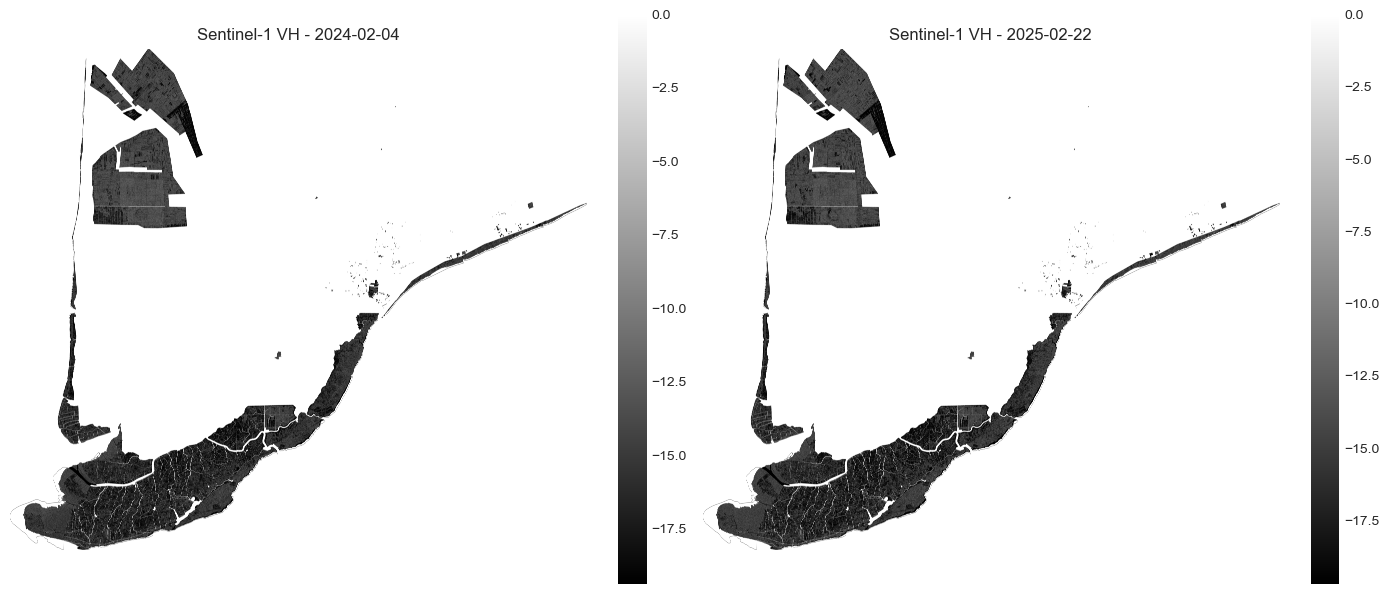

In [9]:
# Visualize Sentinel-1 VH polarization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

im1 = axes[0].imshow(s1_2024_vh[0], cmap='gray', 
                     vmin=np.nanpercentile(s1_2024_vh, 2),
                     vmax=np.nanpercentile(s1_2024_vh, 98))
axes[0].set_title('Sentinel-1 VH - 2024-02-04')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

im2 = axes[1].imshow(s1_2025_vh[0], cmap='gray',
                     vmin=np.nanpercentile(s1_2025_vh, 2),
                     vmax=np.nanpercentile(s1_2025_vh, 98))
axes[1].set_title('Sentinel-1 VH - 2025-02-22')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

plt.tight_layout()
# Save figure
plt.savefig(FIGURES_DIR / '04_s1_vh_comparison.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '04_s1_vh_comparison.png'}")
plt.show()

## 4. Visualize RGB Composite và Spectral Indices

Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\05_s2_false_color_2024.png


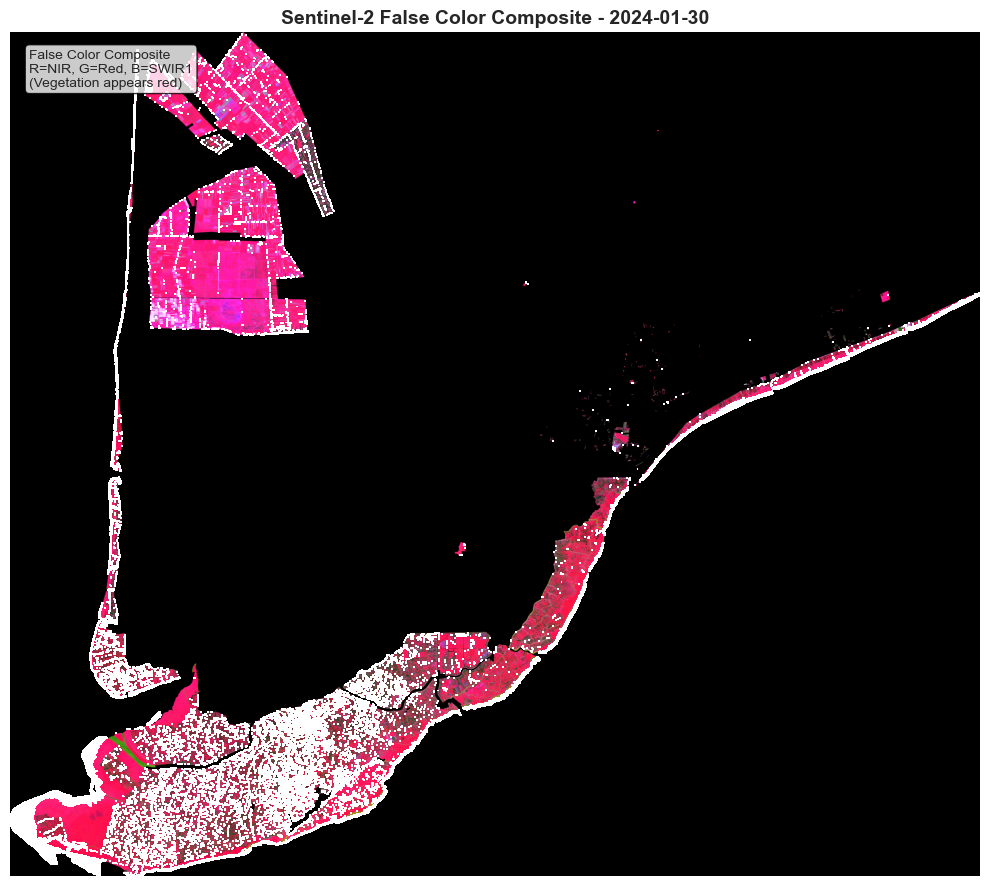

Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\06_s2_false_color_2025.png


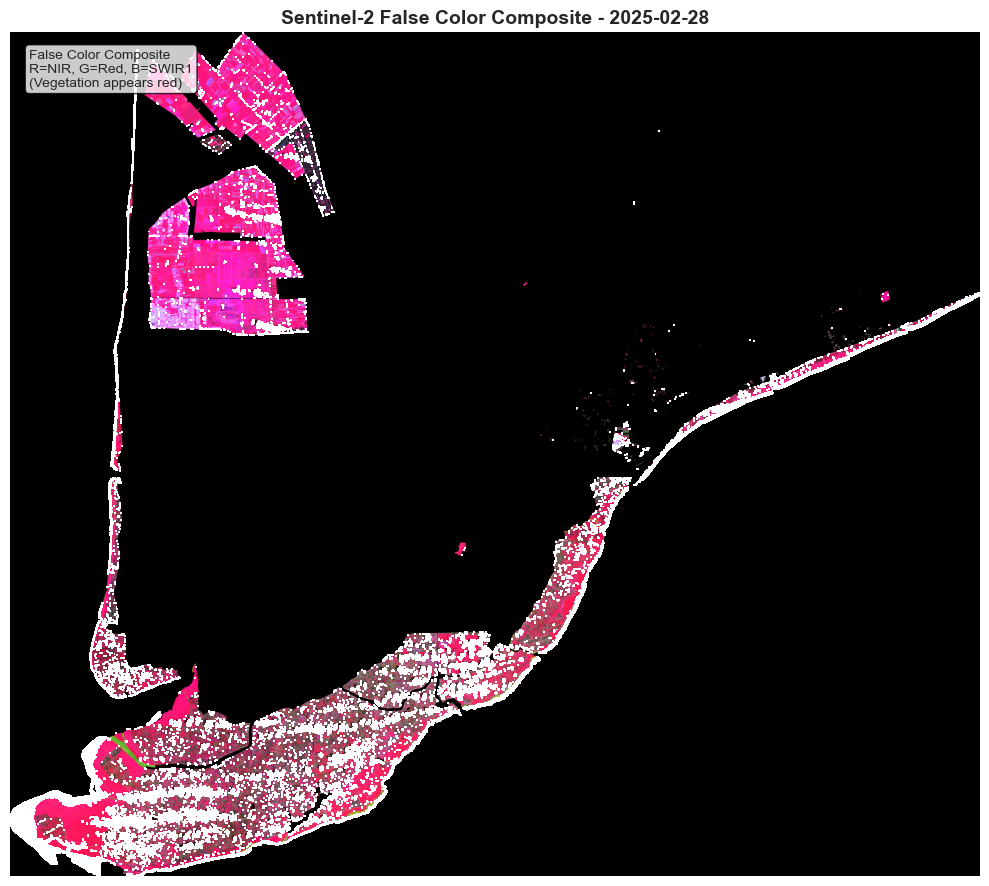

In [10]:
# Create False Color Composite for forest visualization
# R = NIR (B8), G = Red (B4), B = SWIR1 (B11)
# This combination enhances vegetation and forest features
def create_false_color_composite(s2_image, title, percentile=2, save_name=None):
    """
    Create False Color Composite from Sentinel-2 image
    R = NIR (B8) - index 1
    G = Red (B4) - index 0  
    B = SWIR1 (B11) - index 2
    """
    # Stack bands: R=NIR, G=Red, B=SWIR1
    rgb = np.stack([s2_image[1], s2_image[0], s2_image[2]], axis=-1)
    
    # Percentile stretch for better visualization
    p_low, p_high = np.nanpercentile(rgb, (percentile, 100-percentile))
    rgb_stretched = np.clip((rgb - p_low) / (p_high - p_low), 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_stretched)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.text(0.02, 0.98, 'False Color Composite\nR=NIR, G=Red, B=SWIR1\n(Vegetation appears red)', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.axis('off')
    plt.tight_layout()
    
    # Save if save_name is provided
    if save_name:
        plt.savefig(FIGURES_DIR / save_name, dpi=300, bbox_inches='tight')
        print(f"Saved: {FIGURES_DIR / save_name}")
    
    plt.show()

# Visualize both time periods
create_false_color_composite(s2_2024, 'Sentinel-2 False Color Composite - 2024-01-30', save_name='05_s2_false_color_2024.png')
create_false_color_composite(s2_2025, 'Sentinel-2 False Color Composite - 2025-02-28', save_name='06_s2_false_color_2025.png')

Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\07_spectral_indices.png


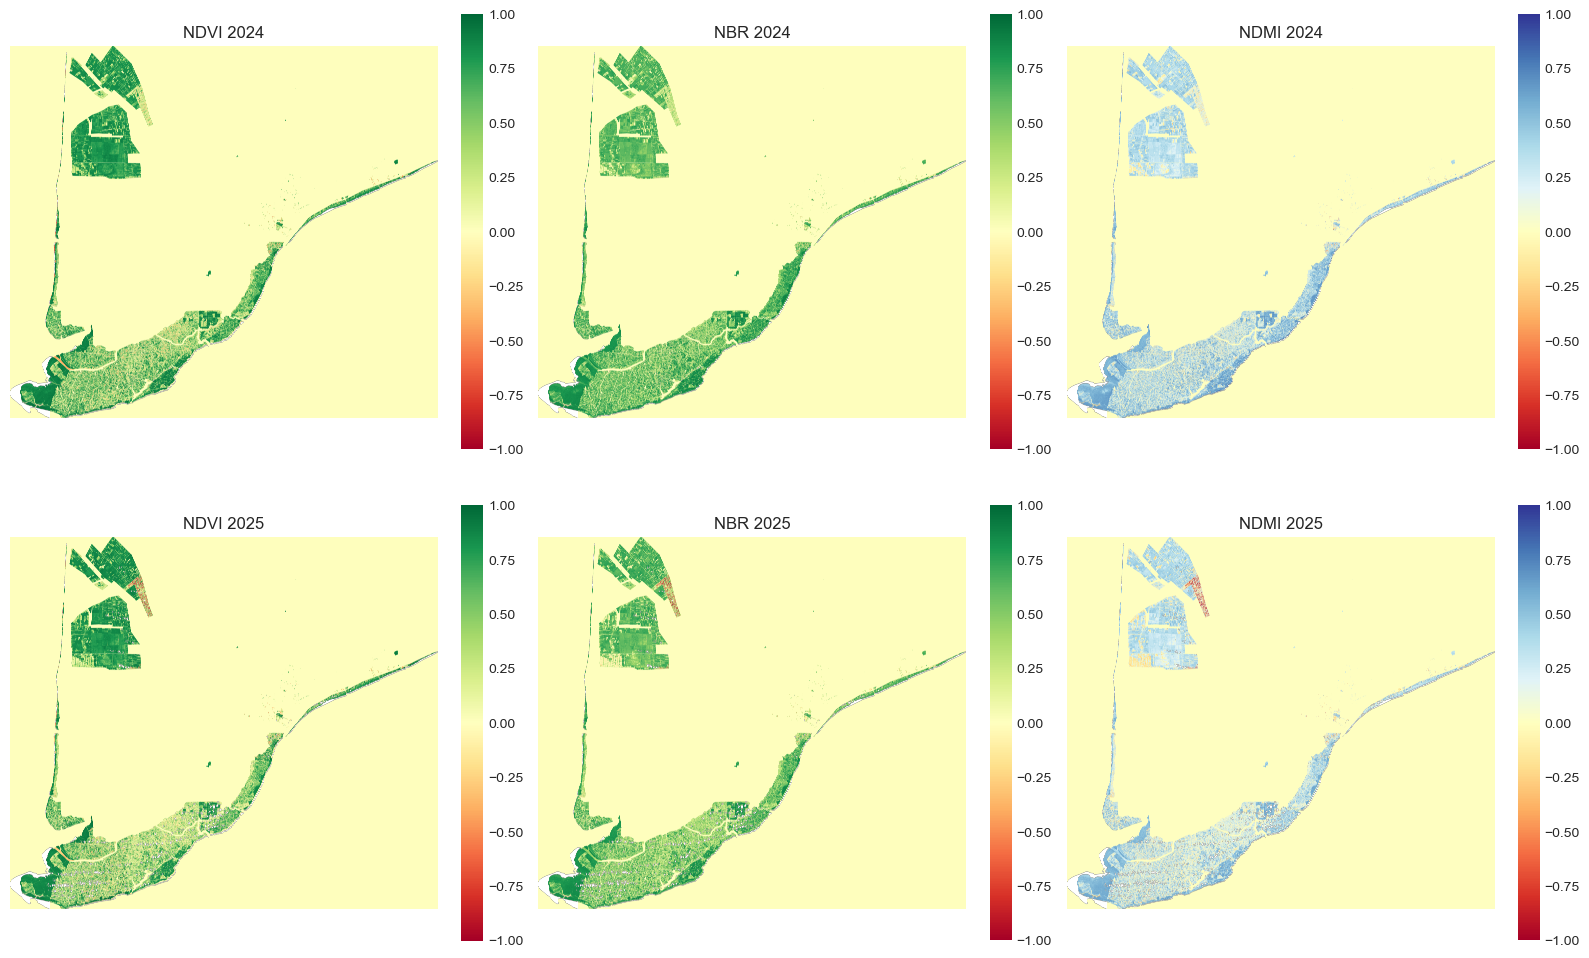

In [11]:
# Visualize spectral indices (NDVI, NBR, NDMI)
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 2024 indices (assuming order: B4, B8, B11, B12, NDVI, NBR, NDMI)
ndvi_2024 = s2_2024[4]  # NDVI is band 5
nbr_2024 = s2_2024[5]   # NBR is band 6
ndmi_2024 = s2_2024[6]  # NDMI is band 7

# 2025 indices
ndvi_2025 = s2_2025[4]
nbr_2025 = s2_2025[5]
ndmi_2025 = s2_2025[6]

# Plot NDVI
im1 = axes[0, 0].imshow(ndvi_2024, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 0].set_title('NDVI 2024')
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[1, 0].imshow(ndvi_2025, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 0].set_title('NDVI 2025')
axes[1, 0].axis('off')
plt.colorbar(im2, ax=axes[1, 0], fraction=0.046)

# Plot NBR
im3 = axes[0, 1].imshow(nbr_2024, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 1].set_title('NBR 2024')
axes[0, 1].axis('off')
plt.colorbar(im3, ax=axes[0, 1], fraction=0.046)

im4 = axes[1, 1].imshow(nbr_2025, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1, 1].set_title('NBR 2025')
axes[1, 1].axis('off')
plt.colorbar(im4, ax=axes[1, 1], fraction=0.046)

# Plot NDMI
im5 = axes[0, 2].imshow(ndmi_2024, cmap='RdYlBu', vmin=-1, vmax=1)
axes[0, 2].set_title('NDMI 2024')
axes[0, 2].axis('off')
plt.colorbar(im5, ax=axes[0, 2], fraction=0.046)

im6 = axes[1, 2].imshow(ndmi_2025, cmap='RdYlBu', vmin=-1, vmax=1)
axes[1, 2].set_title('NDMI 2025')
axes[1, 2].axis('off')
plt.colorbar(im6, ax=axes[1, 2], fraction=0.046)

plt.tight_layout()
# Save figure
plt.savefig(FIGURES_DIR / '07_spectral_indices.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '07_spectral_indices.png'}")
plt.show()

## 5. Visualize Ground Truth Points trên ảnh

In [12]:
# Convert coordinates to pixel positions
df['col'] = 0
df['row'] = 0

for idx, row in df.iterrows():
    col, row_val = coords_to_pixel(row['x'], row['y'], s2_2024_transform)
    df.at[idx, 'col'] = col
    df.at[idx, 'row'] = row_val

print("Converted coordinates to pixel positions")
print(df[['x', 'y', 'col', 'row', 'label']].head())

Converted coordinates to pixel positions
               x             y   col  row  label
0  495551.110218  1.054432e+06  3010  138      1
1  495451.786737  1.054588e+06  3000  123      1
2  495391.097161  1.054524e+06  2994  129      1
3  495664.635289  1.054353e+06  3021  146      1
4  495610.798117  1.054299e+06  3016  152      1


Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\08_ground_truth_points.png


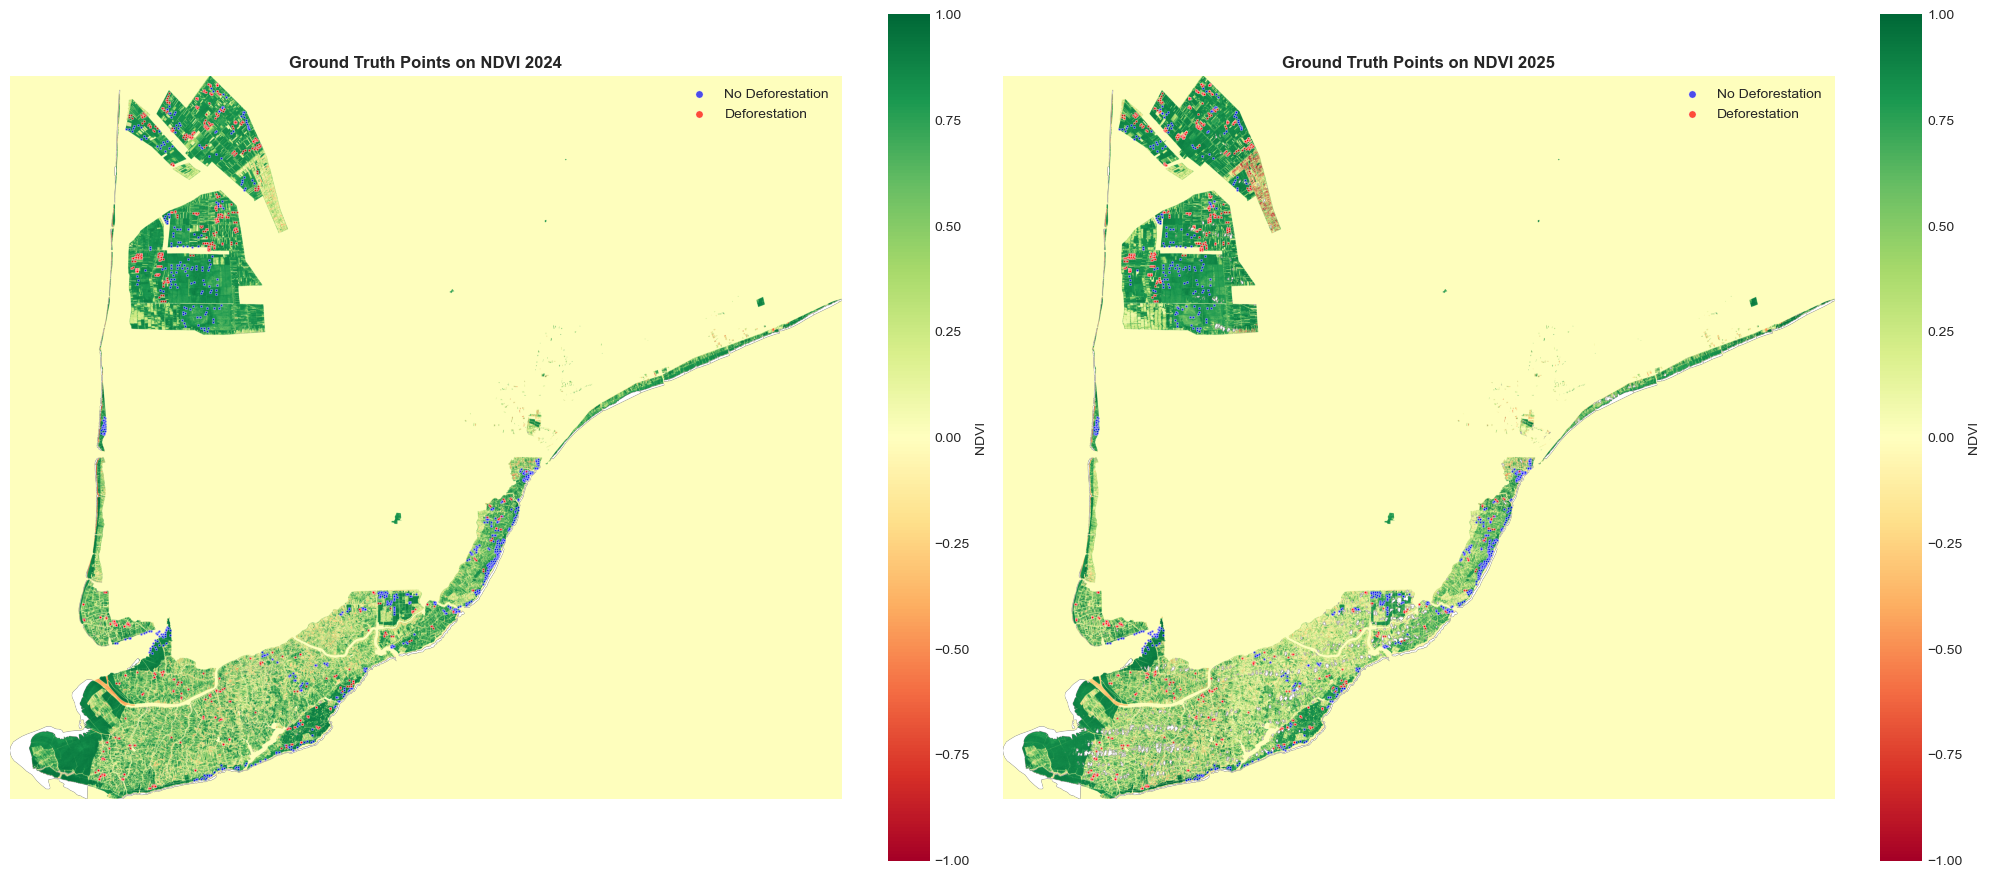

In [13]:
# Plot ground truth points on NDVI images for both years
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Get point subsets
deforestation_points = df[df['label'] == 1]
no_deforestation_points = df[df['label'] == 0]

# NDVI 2024
im1 = axes[0].imshow(ndvi_2024, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].scatter(no_deforestation_points['col'], no_deforestation_points['row'],
                c='blue', s=3, alpha=0.7, label='No Deforestation', edgecolors='white', linewidths=0.3)
axes[0].scatter(deforestation_points['col'], deforestation_points['row'],
                c='red', s=3, alpha=0.7, label='Deforestation', edgecolors='white', linewidths=0.3)
axes[0].set_title('Ground Truth Points on NDVI 2024', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10, markerscale=3)
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, label='NDVI')

# NDVI 2025
im2 = axes[1].imshow(ndvi_2025, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].scatter(no_deforestation_points['col'], no_deforestation_points['row'],
                c='blue', s=3, alpha=0.7, label='No Deforestation', edgecolors='white', linewidths=0.3)
axes[1].scatter(deforestation_points['col'], deforestation_points['row'],
                c='red', s=3, alpha=0.7, label='Deforestation', edgecolors='white', linewidths=0.3)
axes[1].set_title('Ground Truth Points on NDVI 2025', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10, markerscale=3)
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, label='NDVI')

plt.tight_layout()
# Save figure
plt.savefig(FIGURES_DIR / '08_ground_truth_points.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '08_ground_truth_points.png'}")
plt.show()

## 6. Extract và Visualize Sample Patches

In [14]:
# Normalize images for patch extraction
print("Normalizing images...")
# Sentinel-1: Use minmax normalization (dB values -> [0, 1])
s1_2024_norm = normalize_image(s1_2024_vh, method='minmax')
s1_2025_norm = normalize_image(s1_2025_vh, method='minmax')

# Sentinel-2: Use special normalization to preserve value ranges
# B4, B8, B11, B12: keep [0, 1], NDVI, NBR, NDMI: keep [-1, 1]
s2_2024_norm = normalize_sentinel2(s2_2024)
s2_2025_norm = normalize_sentinel2(s2_2025)

print("Done!")
print(f"S1 2024 range: [{np.nanmin(s1_2024_norm):.3f}, {np.nanmax(s1_2024_norm):.3f}]")
print(f"S2 2024 bands 0-3 range: [{np.nanmin(s2_2024_norm[0:4]):.3f}, {np.nanmax(s2_2024_norm[0:4]):.3f}]")
print(f"S2 2024 bands 4-6 range: [{np.nanmin(s2_2024_norm[4:7]):.3f}, {np.nanmax(s2_2024_norm[4:7]):.3f}]")

Normalizing images...
Done!
S1 2024 range: [0.000, 1.000]
S2 2024 bands 0-3 range: [0.000, 0.983]
S2 2024 bands 4-6 range: [-1.000, 1.000]


Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\09_sample_patches.png


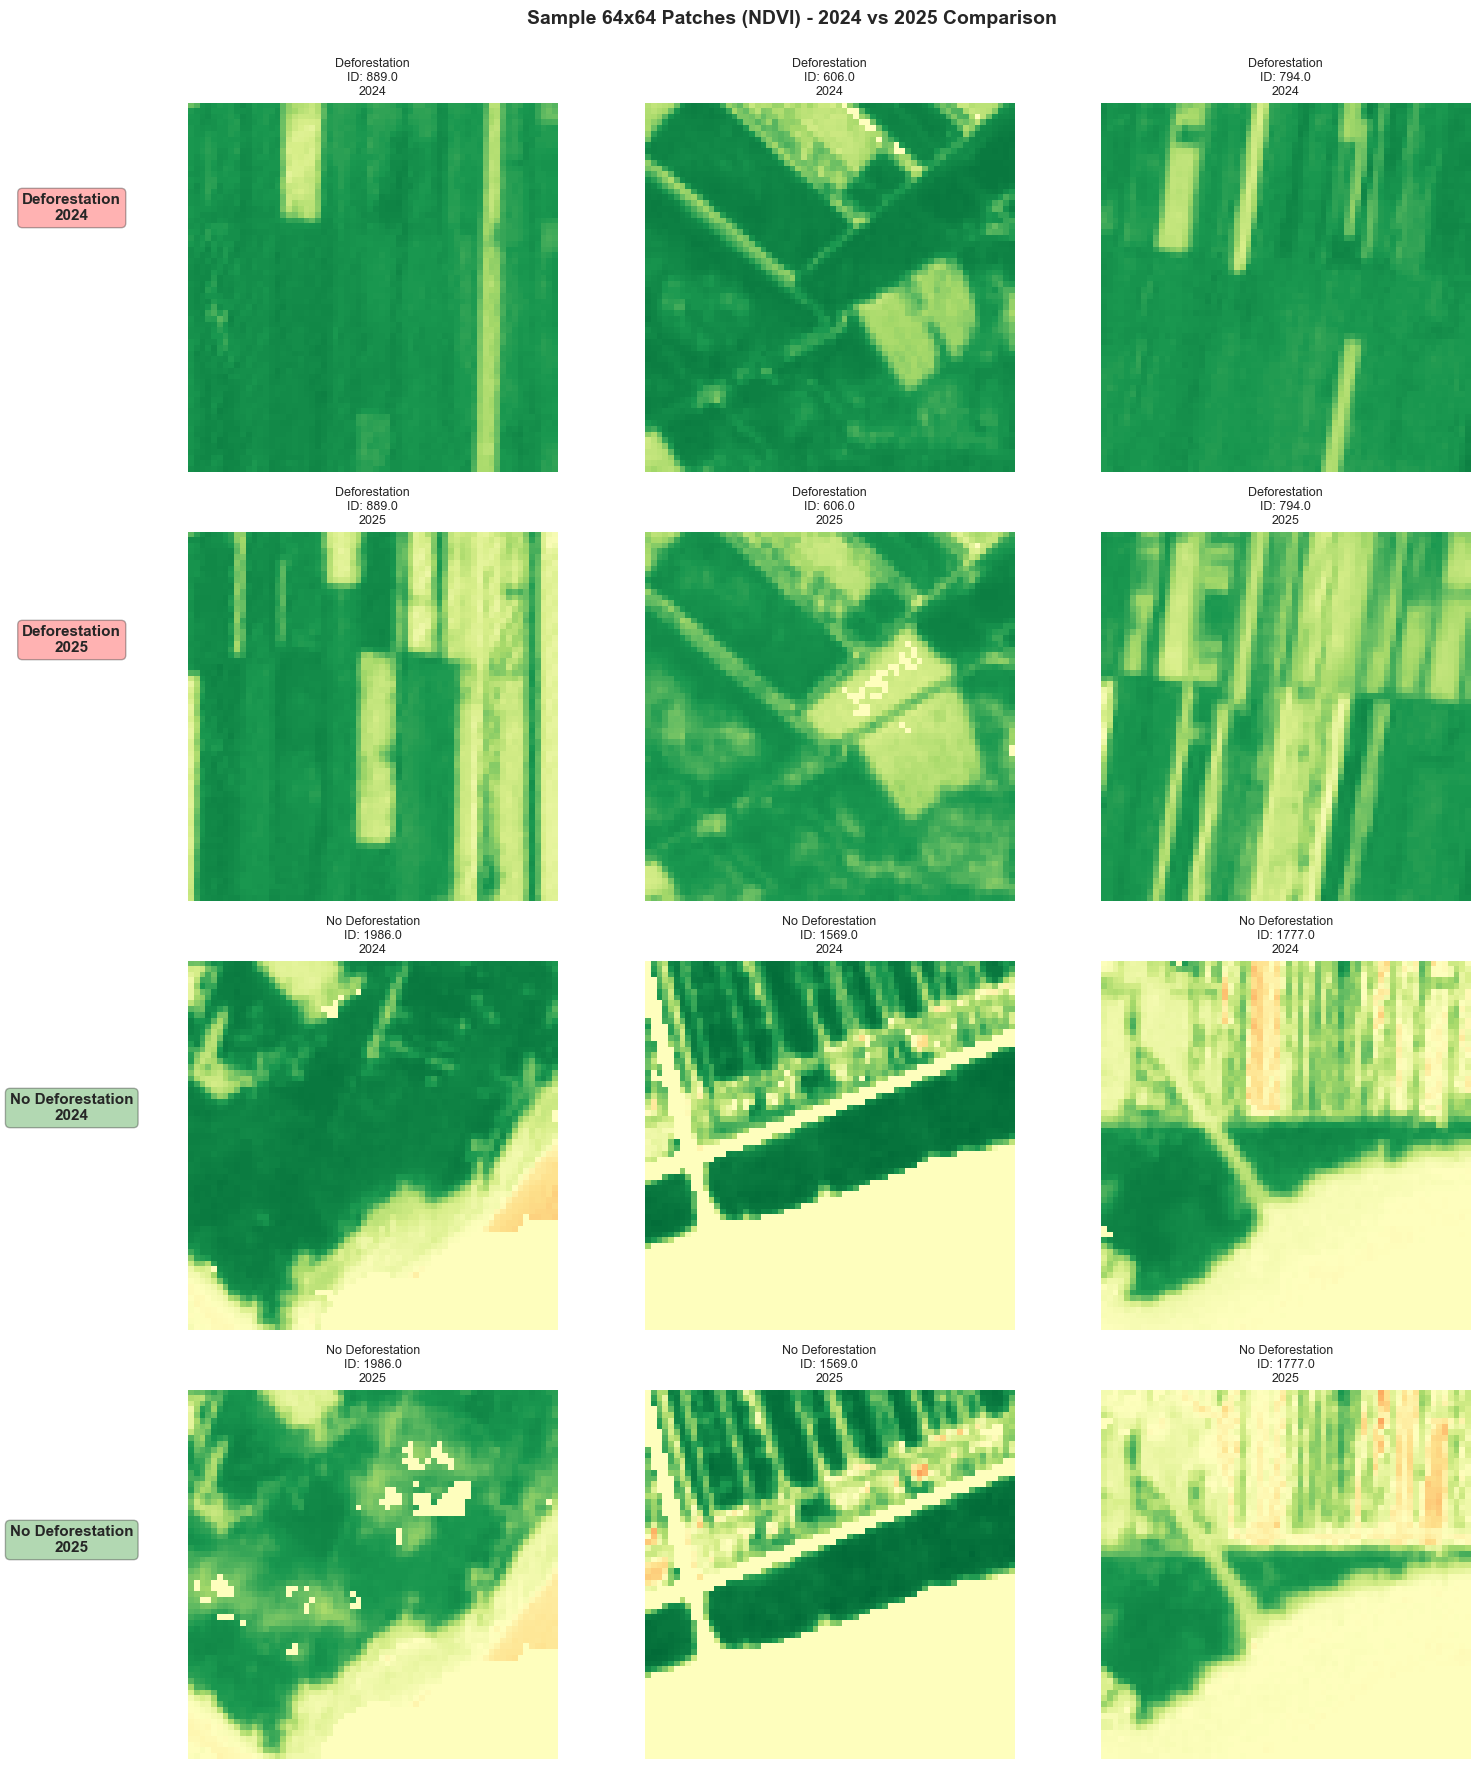

In [15]:
# Extract and visualize patches for both classes and both years
num_samples = 3
patch_size = PATCH_SIZE

# Get sample points
deforestation_samples = df[df['label'] == 1].sample(n=num_samples, random_state=42)
no_deforestation_samples = df[df['label'] == 0].sample(n=num_samples, random_state=42)

fig, axes = plt.subplots(4, num_samples, figsize=(15, 18))

# Extract and plot deforestation patches - 2024
for i, (idx, row) in enumerate(deforestation_samples.iterrows()):
    x, y = row['x'], row['y']
    
    patch = extract_patch_at_point(
        s1_2024_norm, s1_2025_norm, s2_2024_norm, s2_2025_norm,
        x, y, s2_2024_transform, patch_size
    )
    
    if patch is not None:
        # Show NDVI 2024 (band 4) - range [-1, 1]
        axes[0, i].imshow(patch[4], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[0, i].set_title(f'Deforestation\nID: {row["id"]}\n2024', fontsize=9)
        axes[0, i].axis('off')
        
        # Show NDVI 2025 (band 12) - range [-1, 1]
        axes[1, i].imshow(patch[12], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[1, i].set_title(f'Deforestation\nID: {row["id"]}\n2025', fontsize=9)
        axes[1, i].axis('off')

# Extract and plot no deforestation patches - 2024 and 2025
for i, (idx, row) in enumerate(no_deforestation_samples.iterrows()):
    x, y = row['x'], row['y']
    
    patch = extract_patch_at_point(
        s1_2024_norm, s1_2025_norm, s2_2024_norm, s2_2025_norm,
        x, y, s2_2024_transform, patch_size
    )
    
    if patch is not None:
        # Show NDVI 2024 (band 4) - range [-1, 1]
        axes[2, i].imshow(patch[4], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[2, i].set_title(f'No Deforestation\nID: {row["id"]}\n2024', fontsize=9)
        axes[2, i].axis('off')
        
        # Show NDVI 2025 (band 12) - range [-1, 1]
        axes[3, i].imshow(patch[12], cmap='RdYlGn', vmin=-1, vmax=1)
        axes[3, i].set_title(f'No Deforestation\nID: {row["id"]}\n2025', fontsize=9)
        axes[3, i].axis('off')

# Add row labels
fig.text(0.02, 0.87, 'Deforestation\n2024', fontsize=11, fontweight='bold', 
         va='center', ha='center', bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
fig.text(0.02, 0.63, 'Deforestation\n2025', fontsize=11, fontweight='bold',
         va='center', ha='center', bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
fig.text(0.02, 0.37, 'No Deforestation\n2024', fontsize=11, fontweight='bold',
         va='center', ha='center', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))
fig.text(0.02, 0.13, 'No Deforestation\n2025', fontsize=11, fontweight='bold',
         va='center', ha='center', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

fig.suptitle(f'Sample {patch_size}x{patch_size} Patches (NDVI) - 2024 vs 2025 Comparison', 
             fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0.05, 0, 1, 0.98])
# Save figure
plt.savefig(FIGURES_DIR / '09_sample_patches.png', dpi=300, bbox_inches='tight')
print(f"Saved: {FIGURES_DIR / '09_sample_patches.png'}")
plt.show()

Saved: d:\ninhhaidang\25-26_HKI_DATN_21021411_DangNH\notebooks\..\figures\10_multitemporal_patch.png


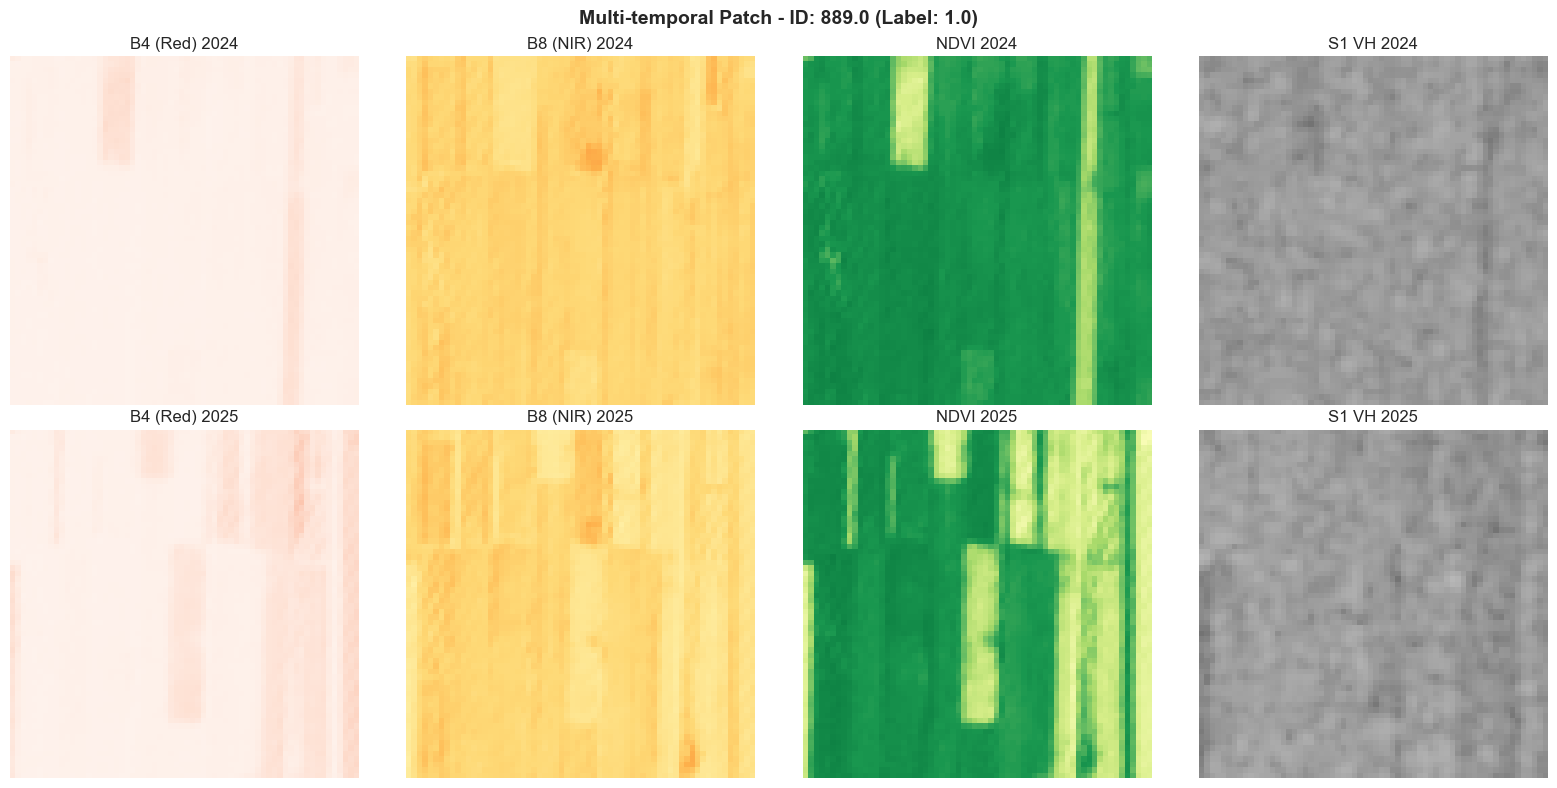

In [16]:
# Visualize multi-temporal comparison for a single patch
sample_point = df[df['label'] == 1].sample(n=1, random_state=42).iloc[0]
x, y = sample_point['x'], sample_point['y']

patch = extract_patch_at_point(
    s1_2024_norm, s1_2025_norm, s2_2024_norm, s2_2025_norm,
    x, y, s2_2024_transform, patch_size
)

if patch is not None:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # 2024 bands (0-7: S2 bands [0-6] + S1 VH [7])
    # B4 (Red) - spectral band [0, 1]
    axes[0, 0].imshow(patch[0], cmap='Reds', vmin=0, vmax=1)
    axes[0, 0].set_title('B4 (Red) 2024')
    axes[0, 0].axis('off')
    
    # B8 (NIR) - spectral band [0, 1]
    axes[0, 1].imshow(patch[1], cmap='YlOrRd', vmin=0, vmax=1)
    axes[0, 1].set_title('B8 (NIR) 2024')
    axes[0, 1].axis('off')
    
    # NDVI - index [-1, 1]
    axes[0, 2].imshow(patch[4], cmap='RdYlGn', vmin=-1, vmax=1)
    axes[0, 2].set_title('NDVI 2024')
    axes[0, 2].axis('off')
    
    # S1 VH - normalized [0, 1]
    axes[0, 3].imshow(patch[7], cmap='gray', vmin=0, vmax=1)
    axes[0, 3].set_title('S1 VH 2024')
    axes[0, 3].axis('off')
    
    # 2025 bands (8-15: S2 bands [8-14] + S1 VH [15])
    # B4 (Red) - spectral band [0, 1]
    axes[1, 0].imshow(patch[8], cmap='Reds', vmin=0, vmax=1)
    axes[1, 0].set_title('B4 (Red) 2025')
    axes[1, 0].axis('off')
    
    # B8 (NIR) - spectral band [0, 1]
    axes[1, 1].imshow(patch[9], cmap='YlOrRd', vmin=0, vmax=1)
    axes[1, 1].set_title('B8 (NIR) 2025')
    axes[1, 1].axis('off')
    
    # NDVI - index [-1, 1]
    axes[1, 2].imshow(patch[12], cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1, 2].set_title('NDVI 2025')
    axes[1, 2].axis('off')
    
    # S1 VH - normalized [0, 1]
    axes[1, 3].imshow(patch[15], cmap='gray', vmin=0, vmax=1)
    axes[1, 3].set_title('S1 VH 2025')
    axes[1, 3].axis('off')
    
    fig.suptitle(f'Multi-temporal Patch - ID: {sample_point["id"]} (Label: {sample_point["label"]})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    # Save figure
    plt.savefig(FIGURES_DIR / '10_multitemporal_patch.png', dpi=300, bbox_inches='tight')
    print(f"Saved: {FIGURES_DIR / '10_multitemporal_patch.png'}")
    plt.show()

## 7. Summary

Từ việc khám phá dữ liệu, chúng ta có thể rút ra:

1. **Ground Truth**: 1285 điểm với phân bố tương đối cân bằng giữa 2 lớp
2. **Sentinel-2**: 7 bands bao gồm spectral bands và indices (NDVI, NBR, NDMI)
3. **Sentinel-1**: VH polarization từ SAR imagery
4. **Patch size**: 64x64 hoặc 128x128 pixels
5. **Total input channels**: 16 channels (2 time periods × 8 bands)

**Next steps**:
- Extract patches cho tất cả ground truth points
- Split data thành train/val/test
- Train deep learning models
- Evaluate và so sánh kết quả